# Pairs Trading Strategy #
The goal is to investigate some potential pairs trading strategies and see how they might perform

## Setup: import dependencies and get data ##

In [1]:
import math
import numpy as np
import pandas as pd
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
import seaborn as sns

## Function to search a set of stocks for cointegrated pairs ##

In [12]:
def find_coint_pairs(data):
    num_stocks = data.shape[1]
    score_matrix = np.zeros((num_stocks, num_stocks))
    pvalue_matrix = np.ones((num_stocks, num_stocks))
    keys = data.keys()
    pairs = []
    for i in range(num_stocks):
        stock1 = data[keys[i]]
        for j in range(num_stocks):
            if i == j:
                continue
            stock2 = data[keys[j]]
            score, pvalue,  *_= coint(stock1, stock2, maxlag = 1)
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
                print(f"Found pair: ({keys[i]}, {keys[j]}) with p value: {pvalue:.4f}")

    return score_matrix, pvalue_matrix, pairs

## Define pairs trading class to analyse a pair once found ##

In [13]:
class PairsTrading():
    def __init__(self, asset1, asset2, model = 'linear'):
        self.asset1 = asset1
        self.asset2 = asset2
        self.ticker1 = asset1.name
        self.ticker2 = asset2.name
        self.model = model
        if model == 'log':
            self.levels1 = np.log(asset1)
            self.levels2 = np.log(asset2)
        else:
            self.levels1 = asset1
            self.levels2 = asset2

        self.hedge_ratio = None
        self.lin_reg_intercept = None
        self.rolling_hedge_ratio = pd.Series()
        self.lookback_window = None
        self.spread = pd.Series()
        self.rolling_spread = pd.Series()
        self.spread_mave = pd.Series()
        self.std_rolling_spread = pd.Series()
        self.stand_rolling_spread = pd.Series()
        self.upper_entry = 1
        self.lower_entry = -1
        self.signals = pd.Series()
    
    # Function to shift data so it starts at value 0. Helps comparisons of two time series
    def shift_data(self, data):
        return data - data.iloc[0]

    # Plot the pairs
    def plot_pairs(self):
        fig, axs = plt.subplots(2, sharex = True, figsize = (15, 5))
        fig.suptitle(f'Comparison of {self.ticker1} and {self.ticker2}')
        self.plot_assets(axs[0], self.levels1, self.levels2)
        self.plot_assets(axs[1], self.shift_data(self.levels1), self.shift_data(self.levels2))
        axs[0].legend([self.ticker1, self.ticker2])
        axs[1].legend([self.ticker1, self.ticker2], loc = 'right')
        if self.model == 'log':
            y_label = 'Log Price'
            y_label_shifted = 'Log Price Shifted'
        else:
            y_label = 'Price'
            y_label_shifted = 'Price Shifted'
        axs[0].set(ylabel = y_label)
        axs[1].set(ylabel = y_label_shifted);

    def plot_assets(self, ax, *assets):
        for asset in assets:
            ax.plot(asset)

    # Calculate hedge ratio on whole data, not rolling
    def calc_hedge_ratio(self):
        if self.model == 'ratio':
            self.hedge_ratio = 1
            return self.hedge_ratio
        
        else:
            X = sm.add_constant(self.levels1)
            lin_model = sm.OLS(self.levels2, X).fit()
            hedge_ratio = lin_model.params[self.ticker1]
            self.hedge_ratio = hedge_ratio
            self.lin_reg_intercept = lin_model.params['const']

        return hedge_ratio

    def plot_regression(self):
        plt.figure(figsize = (15, 5))
        plt.scatter(self.levels2, self.levels1, label = '_')
        if self.model == 'log':
            log_pre = 'Log '
        else:
            log_pre = ''
        plt.ylabel(log_pre + 'Prices ' + self.ticker2)
        plt.xlabel(log_pre + 'Prices ' + self.ticker1)
        if not self.hedge_ratio:
            self.calc_hedge_ratio()
        plt.plot(self.lin_reg_intercept + self.hedge_ratio * self.levels1, self.levels1, color = 'black', label = 'Regression Line')
        plt.title(self.ticker2 + ' vs ' + self.ticker1)
        plt.legend()

    # Check if a lookback window has been passed or if one has been set previously
    # If not, set the lookback window to be 2 * half-life estimate from fitting OU model
    def check_lookback_window(self, lookback_window):
        if not lookback_window and not self.lookback_window:
            print('Setting half-life based lookback window')
            self.lookback_window = int(2 * self.calc_half_life(print_out = False))
    
    # Calculate rolling hedge ration using lookback window
    def calc_rolling_hedge_ratio(self, lookback_window = None):
        # Check if no lookback window has been set and compute default lookback window
        self.check_lookback_window(lookback_window)

        if lookback_window:
            print(f'Setting lookback window to {lookback_window}')
            self.lookback_window = lookback_window
            
        if self.model == 'ratio':
            hedge_ratio = pd.Series(1, index = self.asset2.index)
        
        else:
            hedge_ratio = [np.nan] * self.lookback_window
            intercept = [np.nan] * self.lookback_window
            for date in range(self.lookback_window, len(self.asset1)):
                y = self.levels2[(date - self.lookback_window): date]
                X = self.levels1[(date - self.lookback_window): date]
                lin_model_params = sm.OLS(y, sm.add_constant(X)).fit().params
                hedge_ratio.append(lin_model_params.iloc[1])
        
            hedge_ratio = pd.Series(hedge_ratio, index = self.asset2.index)
        
        self.rolling_hedge_ratio = hedge_ratio
        
        return hedge_ratio

    # Calculate spread on whole data, not rolling
    def calc_spread(self):
        if not self.hedge_ratio:
            self.calc_hedge_ratio()

        if self.model == 'ratio':
            spread = self.levels2 / self.levels1
        else:
            spread = self.levels2 - self.hedge_ratio * self.levels1
        spread.name = 'Spread'
        self.spread = spread

        return spread

    # Calculate rolling spread using lookback window
    def calc_rolling_spread(self, lookback_window = None):
        # Check if no lookback window has been set and compute default lookback window
        self.check_lookback_window(lookback_window)
        
        if lookback_window and self.lookback_window != lookback_window:
            print(f'Resetting lookback window from {self.lookback_window} to {lookback_window}')
            self.lookback_window = lookback_window
            self.calc_rolling_hedge_ratio()

        if self.rolling_hedge_ratio.empty:
            self.calc_rolling_hedge_ratio()

        if self.model == 'ratio':
            rolling_spread = self.levels2 / self.levels1
        else:
            rolling_spread = self.levels2 - self.rolling_hedge_ratio * self.levels1
        rolling_spread.name = 'Rolling Spread'
        self.rolling_spread = rolling_spread
        self.spread_mave = self.rolling_spread.rolling(window = self.lookback_window).mean()
        self.spread_mave.name = 'Spread Moving Average'
        std_rolling_spread = self.rolling_spread.rolling(window = self.lookback_window).std()
        self.std_rolling_spread = std_rolling_spread
        self.std_rolling_spread.name = 'Spread Moving Average Standard Deviation'
        self.stand_rolling_spread = (self.rolling_spread - self.spread_mave) / std_rolling_spread
        self.stand_rolling_spread.name = 'Standardised Rolling Spread'

        return rolling_spread

    # Estimate half-life of mean reversion by fitting to Ohrenstein-Uhlenbeck process
    def calc_half_life(self, print_out = True):
        if self.spread.empty:
            self.calc_spread()
            
        delta_spread = (self.spread - self.spread.shift(1)).dropna()
        lin_model = sm.OLS(delta_spread, sm.add_constant(self.spread.shift(1)).dropna()).fit()
        lambda_hat = - lin_model.params['Spread']
        half_life = math.log(2) / lambda_hat
        if print_out:
            print(f'Estimated lambda = {lambda_hat:.4}')
            print(f'Estimated half-life = {half_life:.2} days')

        return half_life
    
    def plot_spread(self):
        if self.spread.empty:
            self.calc_spread()

        self.spread.plot(figsize = (13, 5))
        plt.axhline(self.spread.mean(), color = 'black')
        plt.ylabel('Spread')
        plt.xlabel('Date')
        plt.legend(['Spread', 'Mean'])

    def stand_series(self, series):
        return (series - series.mean()) / np.std(series)

    def plot_stand_spread(self, suppress_bands = False, upper_band = 1, lower_band = -1):
        if self.spread.empty:
            self.calc_spread()
            
        stand_spread = self.stand_series(self.spread)
        stand_spread.plot(figsize = (15, 5), label = 'Standardised Spread')
        plt.axhline(0, color = 'black', label = 'Mean')
        if not suppress_bands:
            plt.axhline(upper_entry, color = 'red', linestyle = '--', label = upper_entry)
            plt.axhline(lower_band, color = 'green', linestyle = '--', label = lower_band)
        plt.ylabel('Standardised Spread')
        plt.title(f'Standardised {self.ticker1}-{self.ticker2} Spread')
        plt.legend()

    def check_entry(self, upper_entry, lower_entry):
        if not upper_entry:
            upper_entry = self.upper_entry
        if not lower_entry:
            lower_entry = self.lower_entry
        return (upper_entry, lower_entry)
    
    def plot_rolling_spread(self, plot_mave = True, plot_intercept = False, lookback_window = None, suppress_bands = True, \
                            upper_band = None, lower_band = None):
        # Check if no lookback window has been set and compute default lookback window
        self.check_lookback_window(lookback_window)
        # Check if entry points are specified. If not, use previously set ones (or default ones)
        upper_band, lower_band = self.check_entry(upper_band, lower_band)

        if lookback_window and lookback_window != self.lookback_window:
            self.lookback_window = lookback_window
            self.calc_rolling_hedge_ratio()
            self.calc_rolling_spread()
        
        if self.rolling_spread.empty:
            self.calc_rolling_spread()

        plt.figure(figsize = (15, 5))
        plt.plot(self.rolling_spread, label = 'Rolling Spread')
        if plot_mave:
            plt.plot(self.spread_mave, label = f'{self.lookback_window}-Day Moving Average (MAVE)')
        if not suppress_bands:
            plt.plot(self.spread_mave + upper_band * self.std_rolling_spread, color = 'red', linestyle = '--', label = f'MAVE + {upper_band} * Vol')
            plt.plot(self.spread_mave + lower_band * self.std_rolling_spread, color = 'red', linestyle = '--', label = f'MAVE - {abs(lower_band)} * Vol')
        plt.ylabel('Spread')
        plt.xlabel('Date')
        plt.legend()

    def plot_stand_rolling_spread(self, suppress_bands = False, suppress_band_labels = False, lookback_window = None, \
                                  upper_band = None, lower_band = None):
        # Check if no lookback window has been set and compute default lookback window
        self.check_lookback_window(lookback_window)
        # Check if entry points are specified. If not, use previously set ones (or default ones)
        upper_band, lower_band = self.check_entry(upper_band, lower_band)

        if lookback_window and lookback_window != self.lookback_window:
            self.lookback_window = lookback_window
            self.calc_rolling_hedge_ratio()
            self.calc_rolling_spread()

        if self.rolling_spread.empty:
            self.calc_rolling_spread()
        
        self.stand_rolling_spread.plot(figsize = (15, 5), label = 'Standarised Rolling Spread')
        if suppress_band_labels:
            upper_band_label = '_'
            lower_band_label = '_'
            mean_label = '_'
        else:
            upper_band_label = upper_band
            lower_band_label = lower_band
            mean_label = 'Mean'
        plt.axhline(0, color = 'black', label = mean_label)
        if not suppress_bands:
            plt.axhline(upper_band, color = 'red', linestyle = '--', label = upper_band_label)
            plt.axhline(lower_band, color = 'green', linestyle = '--', label = lower_band_label)
        plt.title(self.ticker1 + ' vs ' + self.ticker2 + f' Spread with {self.lookback_window}-Day Moving Average')
        plt.ylabel('Standardised Spread')
        plt.xlabel('Date')
        plt.legend(loc = 'lower right')
    
    def create_trading_signals(self, lookback_window = None, upper_entry = None, lower_entry = None):
        # Check if no lookback window has been set and compute default lookback window
        self.check_lookback_window(lookback_window)
        # Check if entry points are specified. If not, use previously set ones (or default ones)
        upper_entry, lower_entry = self.check_entry(upper_entry, lower_entry)

        # If the passed parameters are different from the previously set one, recompute the trading signals with the new parameters
        if self.check_parameters(lookback_window, upper_entry, lower_entry):
            self.calc_rolling_hedge_ratio()
            self.calc_rolling_spread()

        if self.rolling_spread.empty:
            self.calc_rolling_spread()

        long_entries = self.stand_rolling_spread < lower_entry
        long_exits = self.stand_rolling_spread >= 0
        short_entries = self.stand_rolling_spread > upper_entry
        short_exits = self.stand_rolling_spread <= 0

        # Create signals from long/short entry and exit
        ones = pd.Series(1, index = self.stand_rolling_spread.index)
        zeros = pd.Series(0, index = self.stand_rolling_spread.index)
        minus_ones = pd.Series(-1, index = self.stand_rolling_spread.index)

        long_signals = ones.where(long_entries).fillna(zeros.where(long_exits))
        long_signals.iloc[0] = 0
        long_signals = long_signals.ffill()
        short_signals = minus_ones.where(short_entries).fillna(zeros.where(short_exits))
        short_signals.iloc[0] = 0
        short_signals = short_signals.ffill()
        self.signals = long_signals + short_signals
        return self.signals

    def check_parameters(self, lookback_window, upper_entry, lower_entry):
        changed = False
        if lookback_window and lookback_window != self.lookback_window:
            print(f'Resetting lookback window from {self.lookback_window} to {lookback_window}')
            self.lookback_window = lookback_window
            changed = True
        if self.upper_entry != upper_entry or self.lower_entry != lower_entry:
            print(f'Resetting entry points from ({self.upper_entry}, {self.lower_entry}) to ({upper_entry}, {lower_entry})')
            self.upper_entry = upper_entry
            self.lower_entry = lower_entry
            changed = True
        
        return changed
    
    def plot_trading_signals(self, on_actual_spread = False, plot_mave = True, lookback_window = None, upper_entry = None, \
                             lower_entry = None, suppress_bands = True):
        # Check if entry points are specified. If not, use previously set ones (or default ones)
        upper, lower = self.check_entry(upper_entry, lower_entry)
        
        # Check if no lookback window has been set and compute default lookback window
        self.check_lookback_window(lookback_window)

        # If the passed parameters are different from the previously set one, recompute the trading signals with the new parameters
        if self.check_parameters(lookback_window, upper, lower):
            self.calc_rolling_hedge_ratio()
            self.calc_rolling_spread()
            self.create_trading_signals(upper_entry = upper, lower_entry = lower)

        if self.signals.empty:
            self.create_trading_signals(upper_entry = upper, lower_entry = lower)

        if not on_actual_spread:
            self.plot_stand_rolling_spread(upper_band = upper, lower_band = lower, suppress_band_labels = True)
            long_p, = plt.plot(self.signals[self.signals == 1].index, self.stand_rolling_spread[self.signals == 1], '^',\
                               markersize = 10, color = 'green', label = 'Long Position')
            short_p, = plt.plot(self.signals[self.signals == -1].index, self.stand_rolling_spread[self.signals == -1], 'v',\
                                markersize = 10, color = 'red', label = 'Short Position')
            plt.title(f'{self.ticker1} vs {self.ticker2} Standarised Spread based on {self.lookback_window}-Day Moving Average')
            plt.legend()
        else:
            pm = plot_mave
            sb = suppress_bands
            self.plot_rolling_spread(plot_mave = pm, suppress_bands = sb, upper_band = upper, lower_band = lower)
            plt.plot(self.signals[self.signals == 1].index, self.rolling_spread[self.signals == 1], '^', markersize = 10, color = 'green', \
                     label = 'Long Position')
            plt.plot(self.signals[self.signals == -1].index, self.rolling_spread[self.signals == -1], 'v', markersize = 10, color = 'red', \
                     label = 'Short Position')
            plt.title(f'{self.ticker1} vs {self.ticker2} Spread based on {self.lookback_window}-Day Moving Average')
            plt.legend()

    def calc_PnL(self, lookback_window = None, upper_entry = None, lower_entry = None, plot_returns = True):
        # Check if entry points are specified. If not, use previously set ones (or default ones)
        upper, lower = self.check_entry(upper_entry, lower_entry)
        
        # Check if no lookback window has been set and compute default lookback window
        self.check_lookback_window(lookback_window)

        # If the parameters are different from the previously set one, recompute the trading signals with the new parameters
        if self.check_parameters(lookback_window, upper, lower):
            self.calc_rolling_hedge_ratio()
            self.calc_rolling_spread()
            self.create_trading_signals(upper_entry = upper, lower_entry = lower)

        # If no trading signals generated yet, generate the trading signals
        if self.signals.empty:
            self.create_trading_signals(upper_entry = upper, lower_entry = lower)

        tickers = [self.ticker1, self.ticker2]
        assets = [self.asset1, self.asset2]

        self.portfolio = pd.DataFrame({'Position_' + self.ticker1: - self.signals * self.rolling_hedge_ratio, \
                                           'Position_' + self.ticker2: self.signals}).dropna()
        if self.model == 'linear':
            for i in range(len(assets)):
                self.portfolio['Position_' + tickers[i]] *= assets[i]

        if self.model == 'ratio':
            self.portfolio['Position_' + self.ticker1] *= assets[1] / assets[0]
            self.portfolio['Position_' + self.ticker2] *= assets[1]
                
        self.portfolio['GAV'] = sum([abs(self.portfolio['Position_' + ticker]) for ticker in tickers])
        self.portfolio = self.portfolio[self.portfolio['GAV'] != 0]
        self.portfolio['PnL'] = sum([self.portfolio['Position_' + tickers[i]].shift(1) * (assets[i] - assets[i].shift(1)) / assets[i].shift(1) \
                                    for i in range(len(assets))])
        self.portfolio['Returns'] = self.portfolio['PnL'] / (self.portfolio['GAV'].shift(1)).fillna(0)
        self.portfolio['Cum Returns'] = (np.cumprod(1 + self.portfolio['Returns']) - 1)

        if plot_returns and len(self.portfolio['Returns'].dropna()) > 0:
            self.portfolio['Cum Returns'].plot(figsize = (15, 5))
            plt.title(f'{self.ticker1} vs {self.ticker2} Cummulative Returns')
            plt.ylabel('Cummulative Returns')
            plt.xlabel('Date')

        self.APR = self.compute_APR(self.portfolio['Returns'])
        self.Sharpe = self.compute_Sharpe(self.portfolio['Returns'])
        print(f'APR: {100*self.APR:.4}%')
        print(f'Sharpe Ratio: {self.Sharpe:.2}')

    def compute_APR(self, returns):
        returns = returns.dropna()
        if len(returns) == 0:
            return 0.0
        return ((1 + returns).product())**(252 / len(returns)) - 1
    
    def compute_Sharpe(self, returns):
        returns = returns.dropna()
        if len(returns) == 0:
            return 0.0
        return math.sqrt(252) * returns.mean()/returns.std()
        
    def check_cointegration(self, asset_list):
        for asset in asset_list:
            score, pvalue, *_ = adfuller(asset)
            if pvalue > 0.05:
                print(f'{asset.name} is not stationary (p-value: {pvalue:.4f}).')
            else:
                print(f'{asset.name} is stationary (p-value: {pvalue:.4f}).')

    def run_ADF(self):
        if self.spread.empty:
            self.calc_spread()

        asset_list = [self.levels1, self.levels2, self.spread]
        self.check_cointegration(asset_list)

# Load our universe of stocks #

In [14]:
# Download data
def get_data(stocks, start, end):
    stockData = yf.download(stocks, start, end)
    stockData = stockData['Close']
    return stockData

stocks = ['AAPL', 'NFLX', 'GOOG', 'MSFT', 'NVDA', 'AMD', 'MRVL', 'TSEM', 'AMZN', 'TSM', 'INTC', 'ASML', 'QCOM']
endDate = dt.date.fromisoformat('2024-01-10')
startDate = dt.date.fromisoformat('2022-12-20')

prices_df = get_data(stocks, startDate, endDate)

[*********************100%%**********************]  13 of 13 completed


Look for possible cointegrating pairs using linear price spread (vs log or ratio for now)

Found pair: (AMZN, NVDA) with p value: 0.0326
Found pair: (ASML, TSM) with p value: 0.0352
Found pair: (NFLX, AMZN) with p value: 0.0237
Found pair: (NVDA, AMZN) with p value: 0.0389
Found pair: (TSM, ASML) with p value: 0.0275


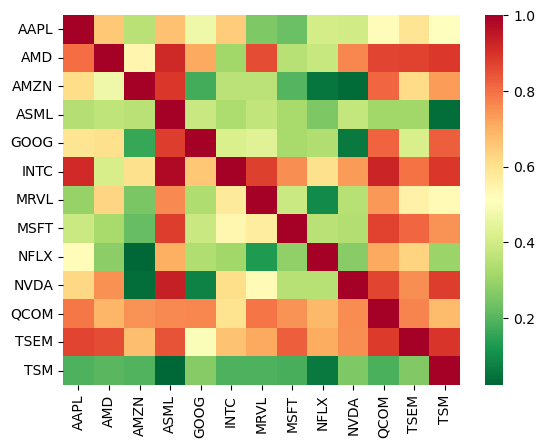

In [18]:
scores, pvalues, pairs = find_coint_pairs(prices_df)
fig, ax = plt.subplots()
ax = sns.heatmap(pvalues, xticklabels = prices_df.columns, yticklabels = prices_df.columns, cmap = 'RdYlGn_r')

Note that we have 78 different pairs (ignoring order), so would expect about 3 - 4 false positives at a 5% test. Since we only have about 3 positives, they could all be false positives!

## Let's look at ASML vs TSM ##

In [19]:
Pairs_ASML_TSM = PairsTrading(prices_df['ASML'], prices_df['TSM'], model = 'ratio')

Run ADF test to see that the ratio of this pair is indeed stationary. Also, plot a comparison of the pair and its spread.

In [20]:
Pairs_ASML_TSM.run_ADF()

ASML is not stationary (p-value: 0.1436).
TSM is not stationary (p-value: 0.1037).
Spread is stationary (p-value: 0.0112).


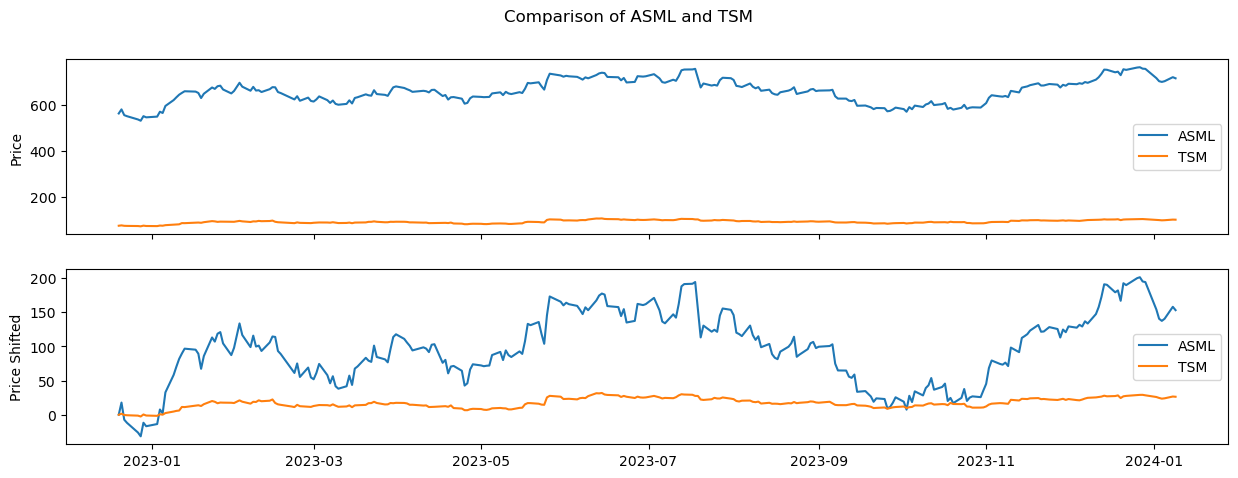

In [21]:
Pairs_ASML_TSM.plot_pairs()

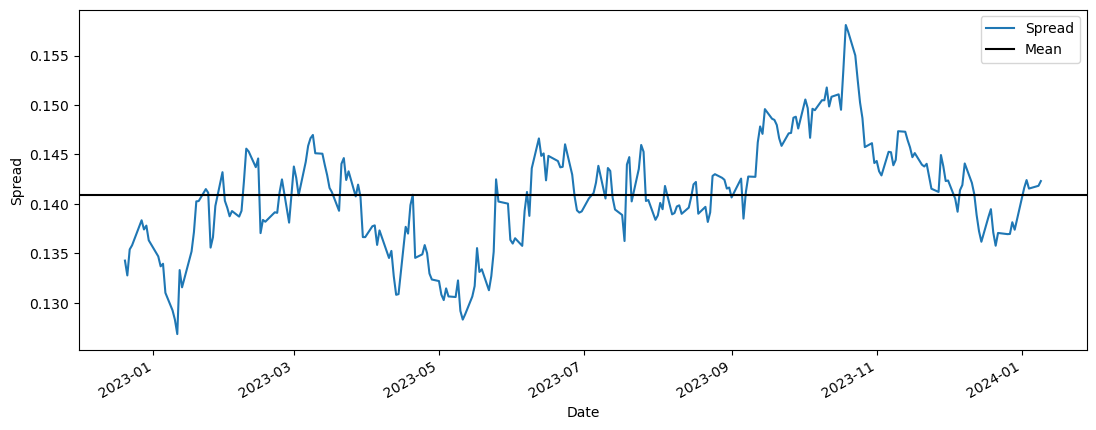

In [22]:
Pairs_ASML_TSM.plot_spread()

Use a rolling window to compute the spread. Fitting Ornstein-Uhlenbeck model to the data suggests a half-life of ~8 days.

In [23]:
Pairs_ASML_TSM.calc_half_life();

Estimated lambda = 0.08172
Estimated half-life = 8.5 days


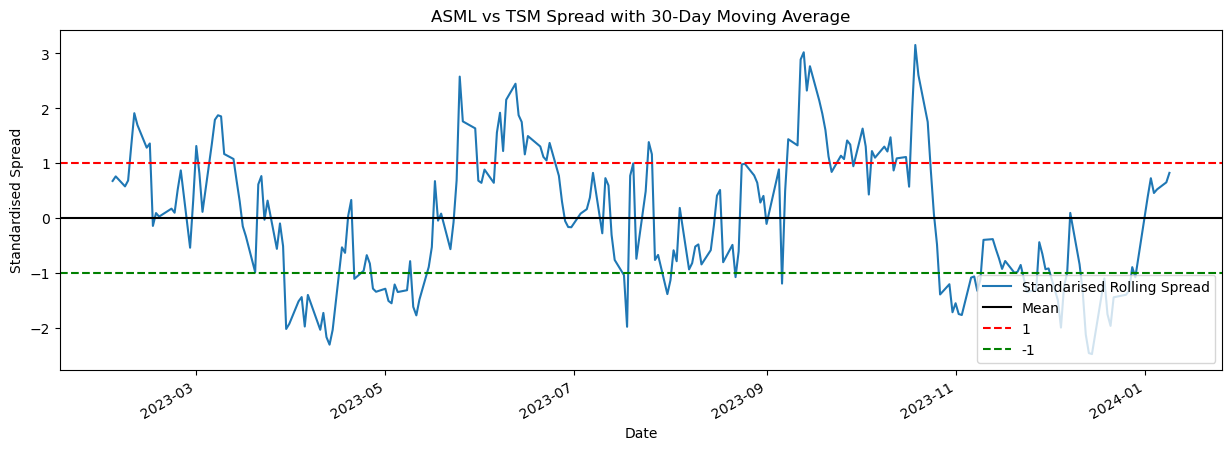

In [24]:
Pairs_ASML_TSM.plot_stand_rolling_spread(lookback_window = 30)

Look at a trading strategy based on a 30-day lookback window.

Resetting entry points from (1, -1) to (1.5, -1.5)


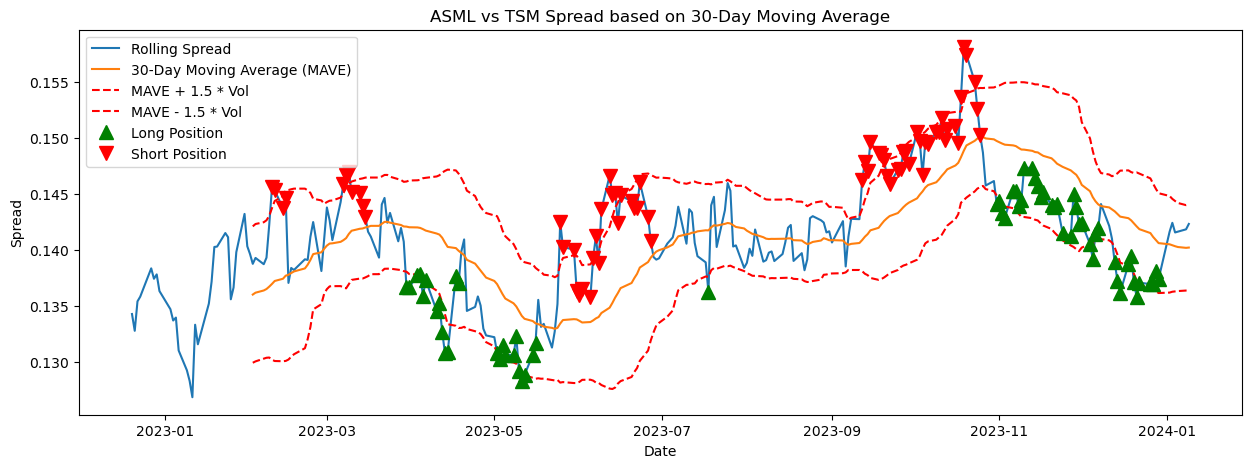

In [25]:
Pairs_ASML_TSM.plot_trading_signals(on_actual_spread = True, suppress_bands = False, lookback_window = 30, upper_entry = 1.5, lower_entry = -1.5)

Calculate P&L of trading strategy

APR: 79.65%
Sharpe Ratio: 2.1


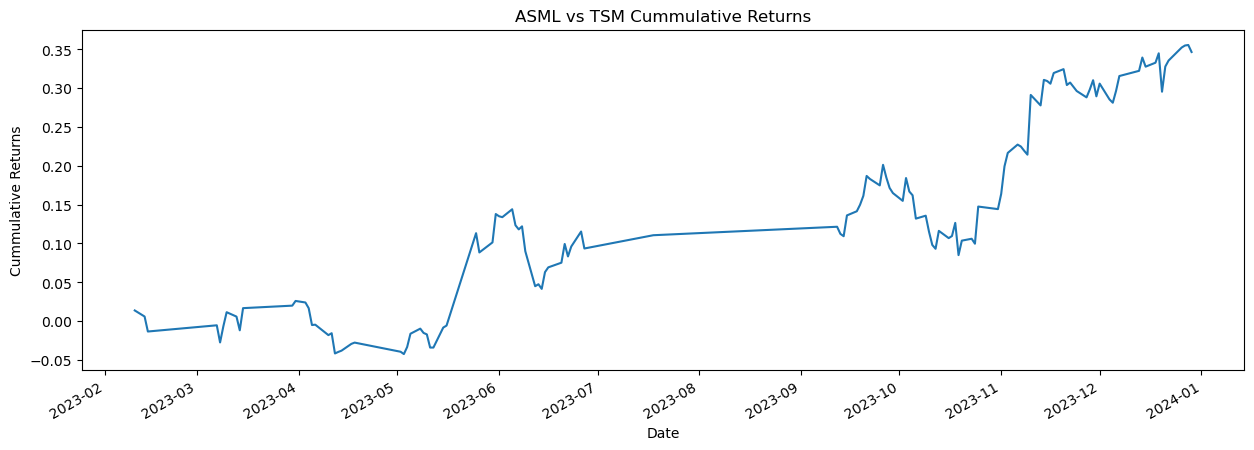

In [26]:
Pairs_ASML_TSM.calc_PnL(lookback_window = 30, upper_entry = 1.5, lower_entry = -1.5)